##  Simulation of a balanced network with I->E plasticity.

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time

In [14]:
# Number of neurons in each population
N = int(10000)
Ne = int(0.8*N)
Ni = int(0.2*N)
# Number of neurons in ffwd layer
Nx = int(0.2*N)

# Recurrent net connection probabilities
P=np.array([[0.1, 0.1], [0.1, 0.1]])
# Ffwd connection probs
Px=np.array([[.1],[.1]])

# Timescale of correlation
taujitter=5
# Mean connection strengths between each cell type pair
Jm=np.array([[25, -100],[112.5, -250]])/np.sqrt(N)
Jxm=np.array([[180],[135]])/np.sqrt(N)

# Total_time (in ms) for sim
T=50000

# Total_time discretization
dt=.1

# Proportions
qe=Ne/N
qi=Ni/N
qf=Nx/N

# FFwd spike train rate (in kHz)
rx=10/1000

# Number of Total_time bins
Nt=round(T/dt)
Total_time=np.arange(dt,T+dt,dt)

# Extra stimulus: Istim is a Total_time-dependent stimulus
# it is delivered to all neurons with weights given by JIstim.
# Specifically, the stimulus to neuron j at Total_time index i is:
# Istim(i)*JIstim(j)
Istim=np.zeros(len(Total_time)) 
Istim[Total_time>T/2]=1
jestim=0
jistim=0.2
Jstim = np.sqrt(N) * np.hstack(( np.transpose( np.array(jestim * np.ones((Ne,1))) ), 
                                np.transpose( np.array(jistim * np.ones((Ni,1))) ) )) 

# Build mean field matrices
Q=[[qe, qi],[qe, qi]];
Qf=[[qf],[qf]];
W=P*(Jm*np.sqrt(N))*Q;
Wx=Px*(Jxm*np.sqrt(N))*Qf;

# Synaptic timescales
taux=10;
taue=8;
taui=4;

# Generate connectivity matrices
# tic

J = np.vstack(( np.hstack((np.array(Jm[0,0] * np.random.binomial(1,P[0,0],(Ne,Ne))), 
              np.array(Jm[0,1] * np.random.binomial(1,P[0,1],(Ne,Ni))))), 
              np.hstack((np.array(Jm[1,0] * np.random.binomial(1,P[1,0],(Ni,Ne))), 
              np.array(Jm[1,1] * np.random.binomial(1,P[1,1],(Ni,Ni))))) ))
 
Jx = np.vstack(( np.array(Jxm[0,0] * np.random.binomial(1,Px[0,0],(Ne,Nx))), 
               np.array(Jxm[1,0] * np.random.binomial(1,P[1,0],(Ni,Nx))) ))

In [15]:
# Generate FFwd spike trains
c=0.1

In [16]:
if(c<1e-5): # If uncorrelated
    nspikeX=np.random.poisson(Nx*rx*T)
    st=np.random.uniform(0,1,(1,nspikeX))*T
    sx=np.zeros((2,len(st[0])))
    sx[0,:]=np.sort(st)[0]
    sx[1,:]=np.random.randint(1,Nx,(1,len(st[0]))) # neuron indices
else: # If correlated
    rm=rx/c # Firing rate of mother process
    nstm=np.random.poisson(rm*T) # Number of mother spikes
    stm=np.random.uniform(0,1,(nstm,1))*T # spike times of mother process    
    maxnsx=int(T*rx*Nx*1.2) # Max num spikes
    sx=np.zeros((2,maxnsx))
    ns=0
    for j in np.arange(1,Nx,1):  # For each ffwd spike train
        ns0=np.random.binomial(nstm,c) # Number of spikes for this spike train
        st=random.sample(list(stm[:,0]),ns0) # Sample spike times randomly
        st=st+taujitter*np.random.normal(0,1,size=len(st)) # jitter spike times
        st=st[(st>0) & (st<T)] # Get rid of out-of-bounds times
        ns0=len(st) # Re-compute spike count
        sx[0,ns+1:ns+ns0+1]=st # Set the spike times and indices        
        sx[1,ns+1:ns+ns0+1]=j
        ns=ns+ns0

    # Get rid of padded zeros
    sx = sx[:,sx[0,:]>0]
    
    # Sort by spike time
    I = np.argsort(sx[0,:])
    sx = sx[:,I]
    nspikeX=len(sx[0,:]);
    

In [17]:
# Neuron parameters
Cm=1
gL=1/15
EL=-72
Vth=-50
Vre=-75
DeltaT=1
VT=-55

In [18]:
# Plasticity parameters
Jmax = 1 #-200/np.sqrt(N)
eta=0.005/Jmax # Learning rate 
tauSTDP=200
rho0=0.010 # Target rate 10Hz
alpha=2*rho0*tauSTDP;

In [19]:
# Maximum number of spikes for all neurons
# in simulation. Make it 50Hz across all neurons
# If there are more spikes, the simulation will terminate
maxns=round(.05*N*T); # was 0.05.


In [20]:
# Indices of neurons to record currents, voltages
nrecord0=100 # Number to record from each population
Irecord=np.array([[random.sample(list(np.arange(0,Ne)),nrecord0) , random.sample(list(np.arange(Ne,N)),nrecord0) ]])
Irecord = Irecord[0,1]
numrecord=len(Irecord) # total number to record

# Synaptic weights to record. 
# The first row of Jrecord is the postsynaptic indices
# The second row is the presynaptic indices
nJrecord0=1000 # Number to record
IIJJ_rec=np.argwhere(J[0:Ne,Ne:N]) # Find non-zero I to E weights
II = IIJJ_rec[:,0]
JJ = IIJJ_rec[:,1]
III=random.sample(list(II),nJrecord0) # Choose some at random to record
II=II[III]
JJ=JJ[III]
Jrecord=np.array([II, JJ+Ne]) # Record these
numrecordJ= len(JJ)

# Number of time bins to average over when recording
nBinsRecord=10
dtRecord=nBinsRecord*dt
timeRecord=np.arange(dtRecord,T+dtRecord,dtRecord)
Ntrec=len(timeRecord)

# Integer division function
def IntDivide(n,k):
    return math.floor((n-1)/k)


In [21]:
# Initialize some variables
# Random initial voltages
V0=np.random.uniform(0,1,(1,N))*(VT-Vre)+Vre;
V=V0
Ie=np.zeros((1,N))
Ii=np.zeros((1,N))
Ix=np.zeros((1,N))
IeRecord=np.zeros((1,N))
IiRecord=np.zeros((1,N))
IxRecord=np.zeros((1,N))
Ie_Record_Wholetime = np.zeros((1,int(T/dt) ))
Ii_Record_Wholetime = np.zeros((1,int(T/dt) ))

x=np.zeros((1,N))
conv_Spike=np.zeros((1,N))
conv_Spike_X=np.zeros((1,Nx))
sum_conv_Spike = np.zeros((1,N))
sum_conv_Spike_X = np.zeros((1,Nx))

IeRec=np.zeros((numrecord,Ntrec))
IiRec=np.zeros((numrecord,Ntrec))
IxRec=np.zeros((numrecord,Ntrec))
# VRec=np.zeros((numrecord,Ntrec))
# wRec=np.zeros((numrecord,Ntrec))
JRec=np.zeros((numrecordJ,Ntrec))
iFspike=0
s=np.zeros((2,maxns))
nspike=0
TooManySpikes=0

record_J = np.zeros((len(J[0,Ne:N]),len(Total_time)))

In [22]:
# Start the simulation.
start_time = time.time()

for i in range(len(Total_time)):
    
    # Propagate ffwd spikes
    while( (sx[0,iFspike]<=Total_time[i]) & (iFspike<nspikeX-1) ):
        jpre=int(sx[1,iFspike])
        Ix=Ix+Jx[:,jpre]/taux
        Spikes_X = np.zeros((1,Nx))
        Spikes_X[0,jpre] = 1
        conv_Spike_X += Spikes_X
        iFspike+=1
    
    # Euler update to V
    V+=(dt/Cm)*(Istim[i]*Jstim+Ie+Ii+Ix+gL*(EL-V)+gL*DeltaT*np.exp((V-VT)/DeltaT))
    
    # Find which neurons spiked
    Ispike=np.argwhere(V>=Vth)[:,1]  
    
    # If there are spikes
    if(len(Ispike)!=0):

        # Store spike times and neuron indices
        if(nspike+len(Ispike)<=maxns):
            s[0,nspike+1:nspike+len(Ispike)+1]=Total_time[i]
            s[1,nspike+1:nspike+len(Ispike)+1]=Ispike
        else:
            TooManySpikes=1
            break        
        
        # Update synaptic currents
        Ie+=np.sum(J[:,Ispike[Ispike<=Ne]],1)/taue
        Ii+=np.sum(J[:,Ispike[Ispike>Ne]],1)/taui            
        
        # Get actual current coming out of each neuron.
        Spikes = np.zeros((1,N))
        Spikes[0,Ispike] = 1
        conv_Spike += Spikes    
        
        # If there is plasticity
        if(eta!=0):
            # Update synaptic weights according to plasticity rules
            # I to E after an I spike 
#             if (Ispike>=Ne)[0]:
            J[0:Ne,Ispike[Ispike>=Ne]]-=np.tile(eta*(x[0,0:Ne]-alpha),(np.count_nonzero(Ispike>=Ne),1)).transpose() * (J[0:Ne,Ispike[Ispike>=Ne]]!=0)
            # I to E after an E spike
#             if (Ispike<Ne)[0]:
            J[Ispike[Ispike<Ne],Ne:N]-=np.tile(eta*x[0,Ne:N].transpose(),(np.count_nonzero(Ispike<Ne),1) ) * (J[Ispike[Ispike<Ne],Ne:N]!=0)
        
        # Update rate estimates for plasticity rules
        x[0,Ispike]+=1
        
        # Update cumulative number of spikes
        nspike+=len(Ispike)
    
    # Euler update to synaptic currents
    Ie-=dt*Ie/taue
    Ii-=dt*Ii/taui
    Ix-=dt*Ix/taux
    conv_Spike[0:Ne,0]-=dt*conv_Spike[0:Ne,0]/taue
    conv_Spike[Ne:N,0]-=dt*conv_Spike[Ne:N,0]/taui
    conv_Spike_X-=dt*conv_Spike_X/taux
    
    
    # Update time-dependent firing rates for plasticity
    x[0:Ne]-=dt*x[0:Ne]/tauSTDP
    x[Ne:N]-=dt*x[Ne:N]/tauSTDP
    
    # This makes plots of V(t) look better.
    # All action potentials reach Vth exactly. 
    # This has no real effect on the network sims
    V[0,Ispike]=Vth
    
    # Store recorded variables
    ii=IntDivide(i,nBinsRecord) 
    IeRec[:,ii]+=Ie[0,Irecord]
    IiRec[:,ii]+=Ii[0,Irecord]
    IxRec[:,ii]+=Ix[0,Irecord]
#     VRec[:,ii]+=V[Irecord]
    JRec[:,ii] += J[Jrecord[0,:],Jrecord[1,:]]
    
    record_J[:,i] = J[0,Ne:N]*np.sqrt(N)
    
    # Reset mem pot.
    V[0,Ispike]=Vre
    
    if i>=T/2/dt:
        sum_conv_Spike += conv_Spike
        sum_conv_Spike_X += conv_Spike_X
        IeRecord += Ie
        IiRecord += Ii
        IxRecord += Ix
    Ie_Record_Wholetime[0,i] = np.mean(Ie[0:Ne])
    Ii_Record_Wholetime[0,i] = np.mean(Ii[0:Ne])

elapsed_time = time.time()-start_time
print(elapsed_time/60, 'minutes')

IeRec=IeRec/nBinsRecord # Normalize recorded variables by # bins
IiRec=IiRec/nBinsRecord
IxRec=IxRec/nBinsRecord
# VRec=VRec/nBinsRecord;
JRec = JRec/nBinsRecord
# did computation online, so now divide to get the average.
IeRecord = IeRecord/(len(Total_time)/2);
IiRecord = IiRecord/(len(Total_time)/2);
IxRecord = IxRecord/(len(Total_time)/2);

s=s[:,0:nspike] # Get rid of padding in s



222.16206981341045 minutes


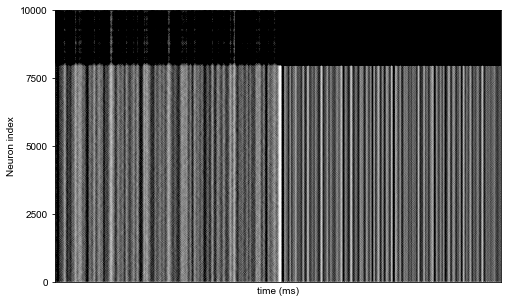

In [23]:
## Make a raster plot of first 500 neurons 
# s(0,:) are the spike times
# s(1,:) are the associated neuron indices

fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":2.3}) 

plt.scatter(s[0,:]/1000,s[1,:],s=0.000002,color='black')
plt.xlabel('time (ms)')
plt.ylabel('Neuron index')
plt.ylim((0,N))
plt.xlim((0,T/1000))

plt.xticks(())

plt.show()

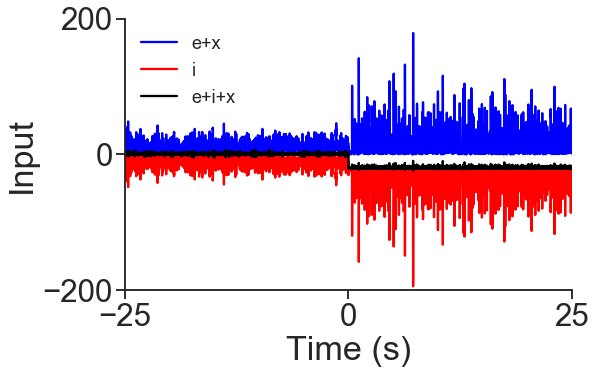

In [80]:
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)
# ax.spines['left'].set_color('black')
# ax.spines['left'].set_linewidth(3)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":2.3}) 

plt.plot(timeRecord/1000-25,np.mean(IeRec,axis=0)+np.mean(IxRec,axis=0),color='blue',label=r'e+x')

plt.plot(timeRecord/1000-25,np.mean(IiRec,axis=0),color='red',label=r'i')

plt.plot(timeRecord/1000-25,np.mean(IeRec,axis=0)+np.mean(IxRec,axis=0)+np.mean(IiRec,axis=0),color='black',label=r'e+i+x')

plt.xlabel('Time (s)')
plt.ylabel('Input')

plt.xticks((-25,0,25))
plt.xlim((-25,25))
plt.yticks((-200,0,200))
plt.ylim((-200,200))

leg = plt.legend(loc='upper left',fontsize=18,frameon='none',markerscale=1)
leg.get_frame().set_linewidth(0.0)

sns.despine()

fig.savefig("/Users/alan/Desktop/Research/NewPaper/Supplement/Input_time_i_stim.pdf", bbox_inches="tight")    

plt.show()


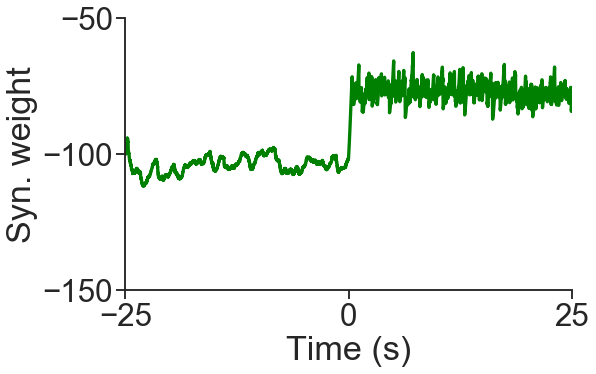

In [61]:
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)
# ax.spines['left'].set_color('black')
# ax.spines['left'].set_linewidth(3)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3}) 

plt.plot(timeRecord/1000-25,np.mean(JRec,0)*np.sqrt(N),color='green')

plt.xlabel('Time (s)')
plt.ylabel('Syn. weight')


plt.xticks((-25,0,25))
plt.xlim((-25,25))
plt.yticks((-150,-100,-50))
plt.ylim((-150,-50))

sns.despine()

fig.savefig("/Users/alan/Desktop/Research/NewPaper/Supplement/Jei_time_i_stim.pdf", bbox_inches="tight")    


plt.show()


In [47]:
# # Define variables from mat file.
# Tburn=1000
# hist, bin_edges = np.histogram(s[1,s[0,:]>Tburn],bins = Ni) 
# riSim = hist / Tburn
# riSim1 = riSim[np.where(record_J[:,0]!=0)]
# record_J1 = record_J[np.where(record_J[:,0]!=0)]
# record_J1 = record_J[np.argsort(riSim)]

In [50]:
# # Start the figure.
# fig=plt.figure(figsize=(8,5))
# ax = plt.subplot(111)

# from matplotlib import cm, colorbar
# import matplotlib as mpl

# sns.set()
# sns.set_style('whitegrid')
# sns.set_style('white')
# sns.set_style("ticks")
# sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":2.5})

# time = np.arange(0,len(record_J1[0,:]))/1000

# n = len(record_J1[:,0])

# color=cm.Greens(np.linspace(0,1,n))
# for i,c in zip(range(n),color):
#     plt.plot( time, record_J1[i,:], c=c)

# plt.xlabel('Time (s)')
# plt.ylabel(r'$I$ weights')

# sns.despine()

# norm = mpl.colors.Normalize(vmin=riSim1.min(), vmax=riSim1.max())
# cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greens)
# cmap.set_array([])

# fig.colorbar(cmap)


# # plt.savefig('./Figure3/Jei_time.pdf',bbox_inches="tight",format="pdf")


# plt.show()

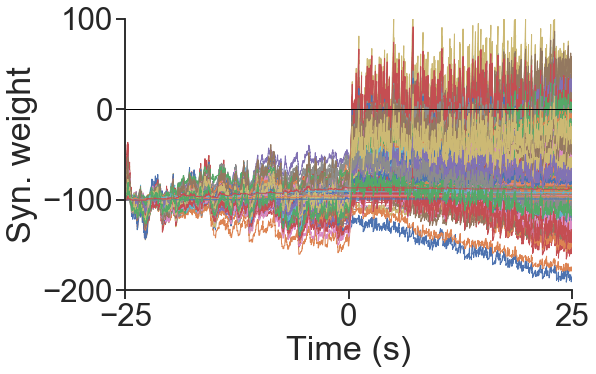

In [62]:
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":1.}) 


for i in range(np.size(np.where(record_J[:,0]))):
    plt.plot(Total_time/1000-25,record_J[np.where(record_J[:,0])[0][i],:])

    
plt.axhline(y=0,color='black')
    
plt.xlabel('Time (s)')
plt.ylabel('Syn. weight')

plt.xticks((-25,0,25))
plt.xlim((-25,25))
plt.yticks((-200,0,-100,100))
plt.ylim((-200,100))

sns.despine()

fig.savefig("/Users/alan/Desktop/Research/NewPaper/Supplement/Jei_individual_time_i_stim.pdf", bbox_inches="tight")    


plt.show()


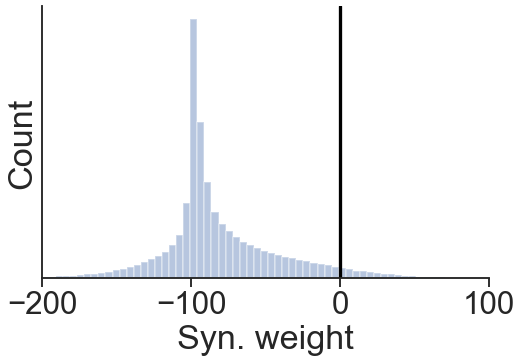

In [56]:
# Histogram of EI weights.
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3})

sns.distplot(np.sqrt(N)*J[0:Ne,Ne:N][np.where(J[0:Ne,Ne:N])],rug=False, kde=False
                  ,bins = 100) 

plt.axvline(x=0, color='black')

# Plot time-dependent rates
# plt.plot((dtRate:dtRate:T)/1000,1000*eRateT)
# plt.plot((dtRate:dtRate:T)/1000,1000*iRateT)
plt.xlabel('Syn. weight')
plt.ylabel('Count')
plt.yticks(())
plt.xticks((-200,-100,0,100))
plt.xlim((-200,100))

sns.despine()

fig.savefig("/Users/alan/Desktop/Research/NewPaper/Supplement/Jei_dist_i_stim.pdf", bbox_inches="tight")    

plt.show()

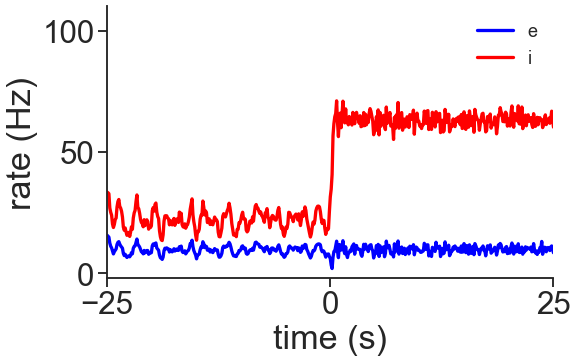

In [78]:
# Time-dependent mean rates
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3}) 

dtRate=100  # ms
timeVector = np.arange(dtRate,T+dtRate,dtRate) /1000 -25
hist, bin_edges = np.histogram(s[0,s[1,:]<Ne]
                  ,bins = len(timeVector)) 

eRateT = hist / (dtRate*Ne) *1000

hist, bin_edges = np.histogram(s[0,s[1,:]>=Ne]
                  ,bins = len(timeVector)) 
iRateT = hist / (dtRate*Ni) *1000

# Slide a window over the rates to smooth them.

window = 5
Num_points = np.int(len(eRateT) - window)

eRate_New = np.zeros((Num_points,1))
iRate_New = np.zeros((Num_points,1))

for i in range(Num_points):
    eRate_New[i,0] = np.mean(eRateT[i:i+window])
    iRate_New[i,0] = np.mean(iRateT[i:i+window])

burnTime = 25

# Plot time-dependent rates
plt.plot(np.linspace(-burnTime,25,num=Num_points),eRate_New,color='blue',label=r'e')
plt.plot(np.linspace(-burnTime,25,num=Num_points),iRate_New,color='red',label=r'i')
# plt.plot((dtRate:dtRate:T)/1000,1000*iRateT)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)')

plt.xticks((-25,0,25))
plt.xlim((-25,25))
plt.yticks((0,50,100))
plt.ylim((-2,110))

sns.despine()


leg = plt.legend(loc='upper right',fontsize=18,frameon='none',markerscale=1)
leg.get_frame().set_linewidth(0.0)

fig.savefig("/Users/alan/Desktop/Research/NewPaper/Supplement/rate_time_i_stim.pdf", bbox_inches="tight")    


plt.show()

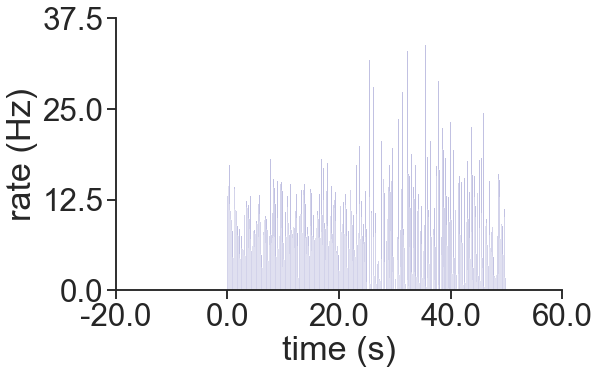

In [30]:
# Histogram of E rates.
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3}) 

dtRate=100  # ms
fig = sns.distplot(s[0,s[1,:]<Ne],rug=False, kde=False,color='darkblue'
                  ,bins = len(np.arange(dtRate,T+dtRate,dtRate))) 
plt.yticks(fig.get_yticks(), 
           fig.get_yticks() / (dtRate*Ne) *1000 )
plt.xticks(fig.get_xticks(), 
           fig.get_xticks() / 1000 )

# Plot time-dependent rates
# plt.plot((dtRate:dtRate:T)/1000,1000*eRateT)
# plt.plot((dtRate:dtRate:T)/1000,1000*iRateT)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)')

sns.despine()

plt.show()

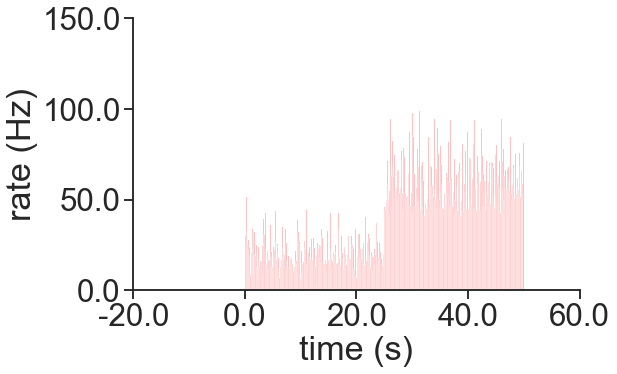

In [31]:
# Histogram of I rates
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3}) 

dtRate=100 # ms
fig = sns.distplot(s[0,s[1,:]>=Ne], color='red',kde=False
                  ,bins = len(np.arange(dtRate,T+dtRate,dtRate))) 
plt.yticks(fig.get_yticks(), 
           fig.get_yticks() / (dtRate*Ni) *1000 )
plt.xticks(fig.get_xticks(), 
           fig.get_xticks() / 1000 )
# Plot time-dependent rates
# plt.plot((dtRate:dtRate:T)/1000,1000*eRateT)
# plt.plot((dtRate:dtRate:T)/1000,1000*iRateT)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)')

sns.despine()

plt.show()

In [188]:
#  Compute spike count covariance matrix.
#  s is a 2x(ns) matrix where ns is the number of spikes
#  s(0,:) lists spike times
#  and s(1,:) lists corresponding neuron indices
#  Neuron indices are assumed to go from 1 to N

#  Spikes are counts starting at time T1 and ending at 
#  time T2.

#  winsize is the window size over which spikes are counted,
#  so winsize is assumed to be much smaller than T2-T1

#  Covariances are only computed between neurons whose
#  indices are listed in the vector Inds. If Inds is not
#  passed in then all NxN covariances are computed.

def SpikeCountCov(s,N,T1,T2,winsize):
 
    Inds=np.arange(0,N)
    
#     Inds=round(Inds)
#      % Check for out of bounds Inds
#      if(min(Inds)<1 || max(Inds)>N)
#          error('Out of bounds indicesin Inds!');
     
#     Check for out of bounds times
#     if(np.max(s[0,:])>T2 | np.min(s[0,:])<T1):
    s1=s[:,(s[0,:]<=T2) & (s[1,:]>=T1)]

#     % Check for out of bounds neuron indices
#     s[1,:]=round(s[1,:])
#     if( np.max(s[1,:])>N | np.min(s[1,:])<1):
#         warning('Ignoring out of bound spike times.')
    s1=s[:,(s[1,:]<N) & (s[1,:]>=0)]

#     % Edges for histogram
    edgest=np.arange(T1,T2, winsize)
    edgesi=np.arange(0,N+1)

#     % Get 2D histogram of spike indices and times
    counts, xedges, yedges = np.histogram2d(s1[0,:], 
                                            s1[1,:],
                                            bins=(edgest, edgesi))

#     % Get rid of edges, which are 0
#     counts=counts[0:-1,0:-1]
#     % Only use counts that are in Inds.
#     counts=counts[:,Inds]

#     % Compute covariance matrix
    return np.array(np.cov(counts.transpose()))

def cov2corr(cov):
    '''convert covariance matrix to correlation matrix

    Parameters
    ----------
    cov : array_like, 2d
        covariance matrix, see Notes

    Returns
    -------
    corr : ndarray (subclass)
        correlation matrix
    return_std : bool
        If this is true then the standard deviation is also returned.
        By default only the correlation matrix is returned.

    Notes
    -----
    This function does not convert subclasses of ndarrays. This requires
    that division is defined elementwise. np.ma.array and np.matrix are allowed.

    '''
    cov = np.asanyarray(cov)
    std_ = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std_, std_)
    return corr

In [189]:
## All the code below computes spike count covariances and correlations
## We want to compare the resulting covariances to what is predicted by
## the theory, first for non-plastic netowrks (eta=0)

# % Compute spike count covariances over windows of size
# % winsize starting at time T1 and ending at time T2.
winsize=250; 
T1=T/2 # Burn-in period of 250 ms
T2=T # Compute covariances until end of simulation
C=SpikeCountCov(s,N,T1,T2,winsize)


# % Get mean spike count covariances over each sub-pop
II,JJ=np.meshgrid(np.arange(0,N),np.arange(0,N))
mCee=np.nanmean(C[(II<Ne) & (JJ<II)])
mCei=np.nanmean(C[(II<Ne) & (JJ>=Ne)])
mCii=np.nanmean(C[(II>Ne) & (JJ>II)])

# Mean-field spike count cov matrix
# Compare this to the theoretical prediction
mC=[[mCee, mCei], [mCei, mCii]]

# Compute spike count correlations
# This takes a while, so make it optional
ComputeSpikeCountCorrs=1
if(ComputeSpikeCountCorrs):
    
#    Get correlation matrix from cov matrix
    start_time = time.time()
    R=cov2corr(C)
    elapsed_time = time.time()-start_time
    print(elapsed_time/60, 'minutes')

    mRee=np.nanmean(R[(II<Ne) & (JJ<II)])
    mRei=np.nanmean(R[(II<Ne) & (JJ>=Ne)])
    mRii=np.nanmean(R[(II>Ne) & (JJ>II)])

    # Mean-field spike count correlation matrix
    mR=[[mRee, mRei], [mRei, mRii]]
    print('mR =',mR)

/opt/anaconda3/envs/bmnn/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


0.0033618013064066568 minutes
mR = [[0.41058572453441716, 0.17517178590178398], [0.17517178590178398, 0.07503718664955243]]


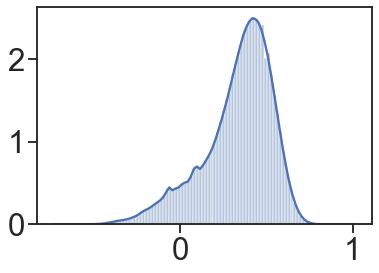

In [190]:
sns.distplot(R[(II<N) & (JJ<II)],bins=100)
plt.show()